# ASSESSING SEASONAL CHANGES IN WATER QUALITY IN WINAM BAY, LAKE VICTORIA, USING SENTINEL-2 DATA
	

By
	Casper Augustine Indoko	
Reg No: ESEQ/01670/2019


* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

1. Load cloud-free Sentinel-2 images for an Winam Bay.
2. Compute indices to measure the presence of water, turbidity and chlorophyll-*a*.
3. Generate informative visualisations to identify trends in the parameters above.


### Load packages
Load key Python packages and supporting functions for the analysis.

In [2]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

from datacube.utils.geometry import Geometry
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.areaofinterest import define_area

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 

To use Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:37645' processes=1 threads=4, memory=26.21 GiB>

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [4]:
dc = datacube.Datacube(app="Chlorophyll_monitoring")

In [ ]:
##Define the extent of Winam Bay

In [5]:
lat, lon = -0.31352, 34.5302

lat_buffer = 0.23
lon_buffer = 0.33

#convert the lat,lon,buffer into a range
lon_range = (lon - lon_buffer, lon + lon_buffer)
lat_range = (lat - lat_buffer, lat + lat_buffer)

# Set the range of dates for the analysis
time = ("2022-01-01", "2023-12-31")

## View the selected location

In [1]:
display_map(x=lon_range, y=lat_range)

NameError: name 'display_map' is not defined

## Load and view Sentinel-2 data

In this step we choose the sentinel 2 product, create a reusable query, set output CRS, and filter dataset

In [7]:
# Choose the Sentinel-2 products to load
products = ["s2_l2a"]

# Create a reusable query
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time,
    "resolution": (-10, 10),
    "measurements": ["red_edge_1",
                    "red",
                    "green",
                    "blue",
                    "nir_1",
                    "swir_1",]
}

# Since this analysis calculates pixel areas,
# set the output projection to equal area projection EPSG:6933
output_crs = "EPSG:6933"

# Load available data from Sentinel-2A and -2B and filter to retain only times
# with at least 90% good data
ds = load_ard(dc=dc, 
              products=products,
              min_gooddata=0.9,
              output_crs=output_crs,
              group_by="solar_day",
              dask_chunks={'time':1, 'x':2000, 'y':2000},
              **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 40 out of 143 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 40 time steps as a dask array


**Once the load is complete**, we examine the data by printing it in the next cell.


In [8]:
ds

<xarray.Dataset>
Dimensions:      (time: 40, y: 5869, x: 6369)
Coordinates:
  * time         (time) datetime64[ns] 2022-03-02T08:09:53 ... 2023-12-22T08:...
  * y            (y) float64 -1.066e+04 -1.066e+04 ... -6.932e+04 -6.934e+04
  * x            (x) float64 3.3e+06 3.3e+06 3.3e+06 ... 3.364e+06 3.364e+06
    spatial_ref  int32 6933
Data variables:
    red_edge_1   (time, y, x) float32 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    nir_1        (time, y, x) float32 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Plot example timestep in true colour

To visualise the data,we use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 


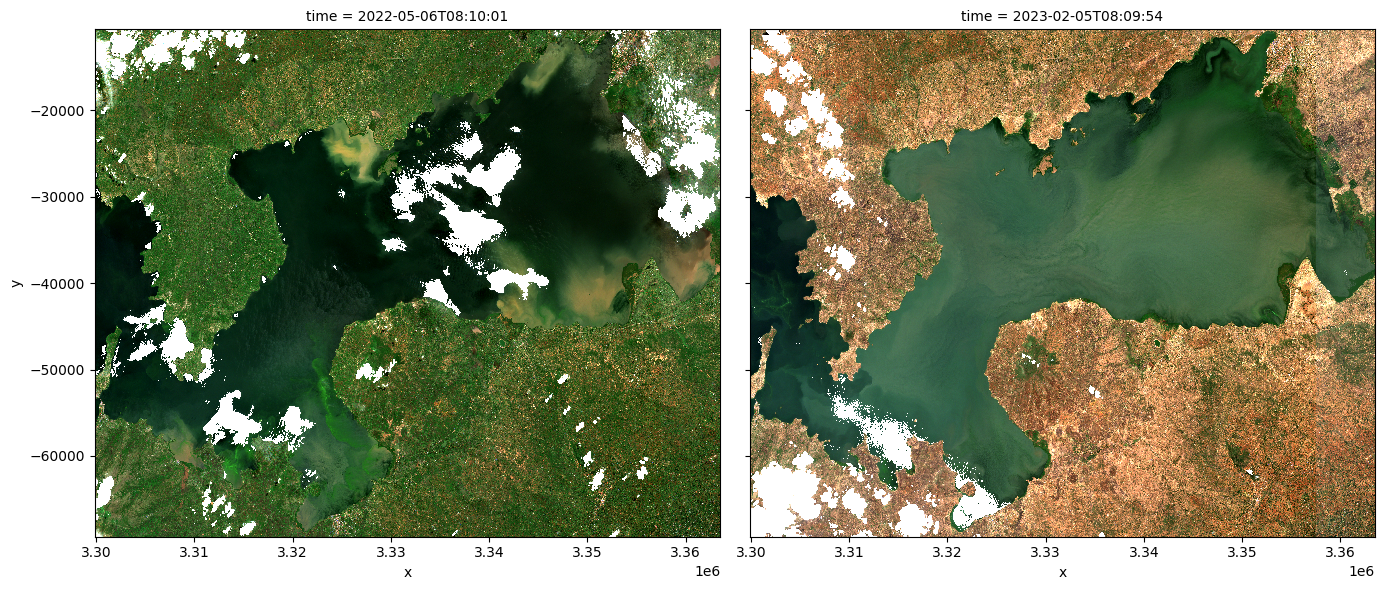

In [9]:
# Set the timesteps to visualise
initial_timestep = 3
final_timestep = 20

# Generate RGB plots at each timestep
rgb(ds, index=[initial_timestep, final_timestep],
    percentile_stretch=[0.01, 0.99])

## Compute band indices

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}.
\end{aligned}
$$


$$
\begin{aligned}
\text{NDCI} = \frac{\text{Red edge 1} - \text{Red}}{\text{Red edge 1} + \text{Red}}.
\end{aligned}
$$


$$
\begin{aligned}
\text{NDTI} = \frac{\text{Red} - \text{Green}}{\text{Red} + \text{Green}}.
\end{aligned}
$$



In [10]:
# Calculate MNDWI and add it to the loaded data set
ds = calculate_indices(ds, index="MNDWI", satellite_mission="s2")

ds = ds.where(ds.MNDWI > 0.0)

# Calculate NDCI and add it to the loaded data set
ds = calculate_indices(ds, index="NDCI", satellite_mission="s2")

# Calculate NDTI and add it to the loaded data set
ds = calculate_indices(ds, index="NDTI", satellite_mission="s2")

## Setting and coming up with seasons

In [11]:
sample_frequency="QS-DEC"  # quatrley starting in DEC, i.e. seasonal+

#resample MNDWI using medians
print('calculating MNDWI medians')
mndwi_QS = ds['MNDWI'].resample(time=sample_frequency).median().compute()
ndci_QS = ds['NDCI'].resample(time=sample_frequency).median().compute()
ndti_QS = ds['NDTI'].resample(time=sample_frequency).median().compute()


calculating MNDWI medians


## Build summary plots
To get an understanding of how the waterbody has changed over time, the following section builds a plot that uses the MNDWI to measure the rough area of the waterbody, along with the NDCI to track how the concentration of clorophyll-*a* is changing over time.
This could be used to quickly assess the status of a given waterbody.

### Set up constants
The number of pixels classified as water (MNDWI > 0) can be used as a proxy for the area of the waterbody if the pixel area is known. 


In [12]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

area_per_pixel = pixel_length**2 / m_per_km**2

### Compute the total water area
The next cell starts by filtering the data set to only keep the pixels that are classified as water. 
It then calculates the water area by counting all of the MNDWI pixels in the filtered data set, calculating a rolling median (this helps smooth the results to account for variation from cloud-masking), then multiplies this median count by the area-per-pixel.


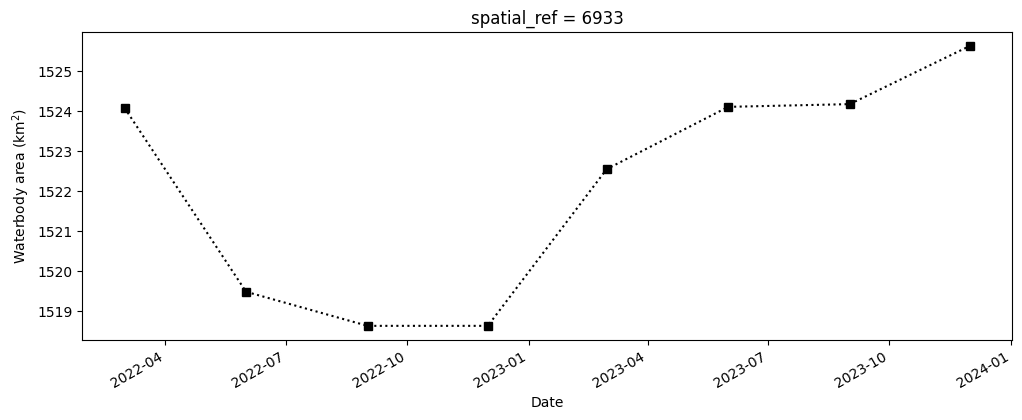

In [13]:

# Calculate the total water area (in km^2)
waterarea = (
    mndwi_QS.count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
).persist()

# Plot the resulting water area through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
waterarea.plot(linestyle=":", marker="s", color="k")
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (km$^2$)")
plt.show()

### Compute the average NDCI and NDTI
The next cell computes the average NDCI and/or NDTI for each time step using the filtered data set.
This means that we're only tracking the NDCI and/or NDTI in waterbody areas, and not on any land.
To make the summary plot, we calculate NDCI and/or NDTI across all pixels; this allows us to track overall changes in NDCI and/or NDTI, but doesn't tell us where the increase occured within the waterbody (this is covered in the next section).

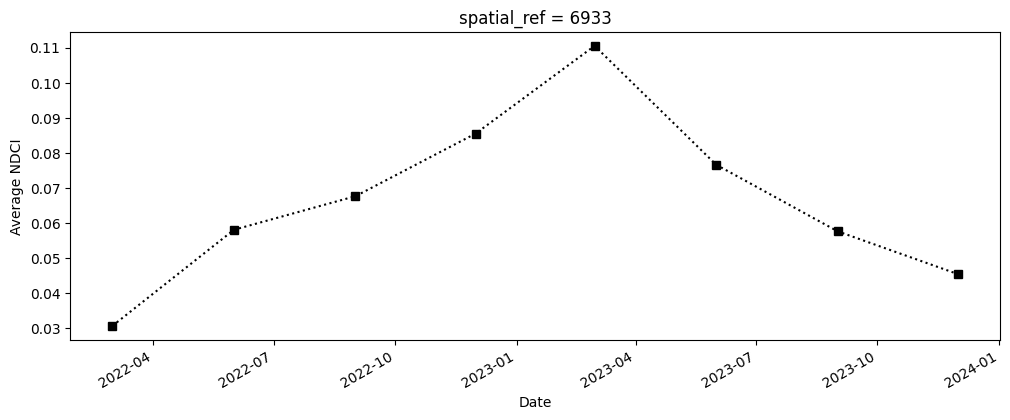

In [14]:
# Calculate the average NDCI
# average_ndci = ds_waterarea.NDCI.mean(dim=["x", "y"], skipna=True).persist()
average_ndci = ndci_QS.mean(dim=["x", "y"], skipna=True).persist()

# Plot average NDCI through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
average_ndci.plot(linestyle=":", marker="s", color="k")
axes.set_xlabel("Date")
axes.set_ylabel("Average NDCI")
plt.show()

In [ ]:
##we the generate time series maps for ndci and ndti over the seasons

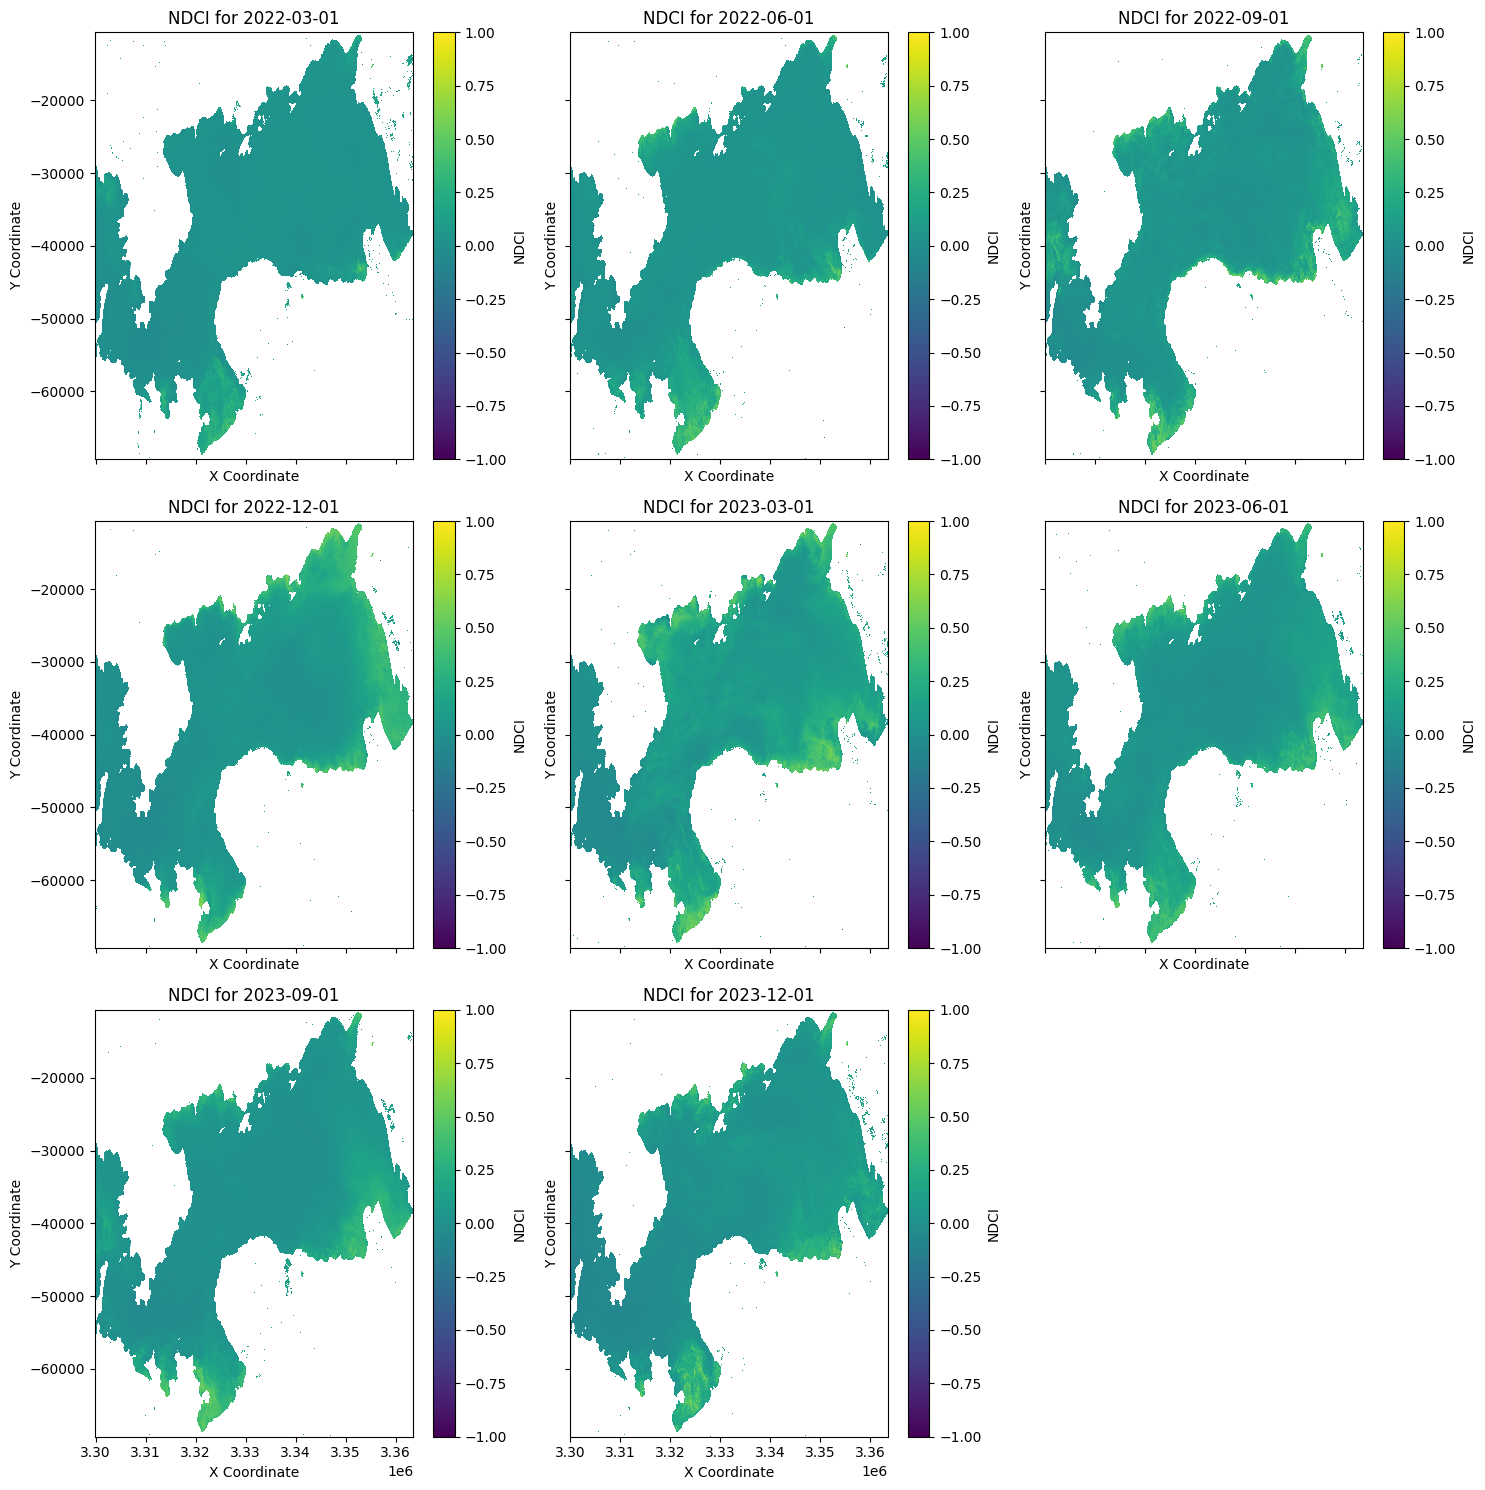

In [15]:
# Plot all time steps with available data
num_time_steps = len(ndci_QS.time)

# Calculate the number of subplots needed based on available time steps
num_cols = 3  # Number of columns for subplots
num_rows = (num_time_steps // num_cols) + (1 if num_time_steps % num_cols else 0)  # Calculate number of rows

# Set figure size based on the number of subplots
fig_width = 15
fig_height = num_rows * 5

# Create the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)

# Flatten axes if necessary
if num_rows == 1:
    axes = [axes]

# Plot each available time step
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        # Calculate the index of the current time step
        step_index = i * num_cols + j
        if step_index < num_time_steps:
            # Extract NDCI values for the current time step
            ndci_slice = ndci_QS.isel(time=step_index)
            # Plot the imagery
            ndci_slice.plot(ax=ax, cmap='viridis', vmin=-1, vmax=1)  # Adjust colormap and vmin/vmax as needed
            # Set the title to display the date of the NDCI image
            date_str = str(ndci_slice.time.values)[:10]  # Extract the date part
            ax.set_title('NDCI for {}'.format(date_str))
            ax.set_xlabel('X Coordinate')
            ax.set_ylabel('Y Coordinate')
        else:
            # If no data available for this subplot, remove it
            ax.axis('off')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


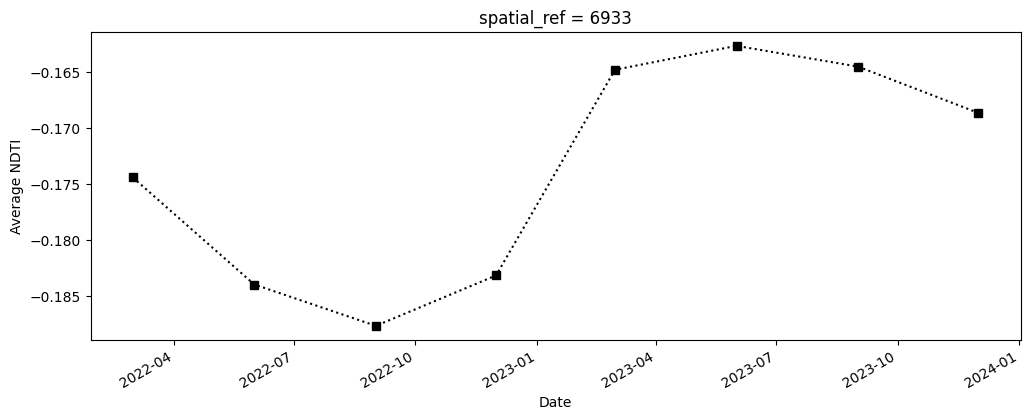

In [15]:
# Calculate the average NDTI
# average_ndti = ds_waterarea.NDTI.mean(dim=["x", "y"], skipna=True).persist()
average_ndti = ndti_QS.mean(dim=["x", "y"], skipna=True).persist()

# Plot average NDTI through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
average_ndti.plot(linestyle=":", marker="s", color="k")
# Calculate the average NDCI
# average_ndci = ds_waterarea.NDCI.mean(dim=["x", "y"], skipna=True).persist()
average_ndci = ndci_QS.mean(dim=["x", "y"], skipna=True).persist()

# Plot average NDCI through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
average_ndci.plot(linestyle=":", marker="s", color="k")
axes.set_xlabel("Date")
axes.set_ylabel("Average NDTI")
plt.show()

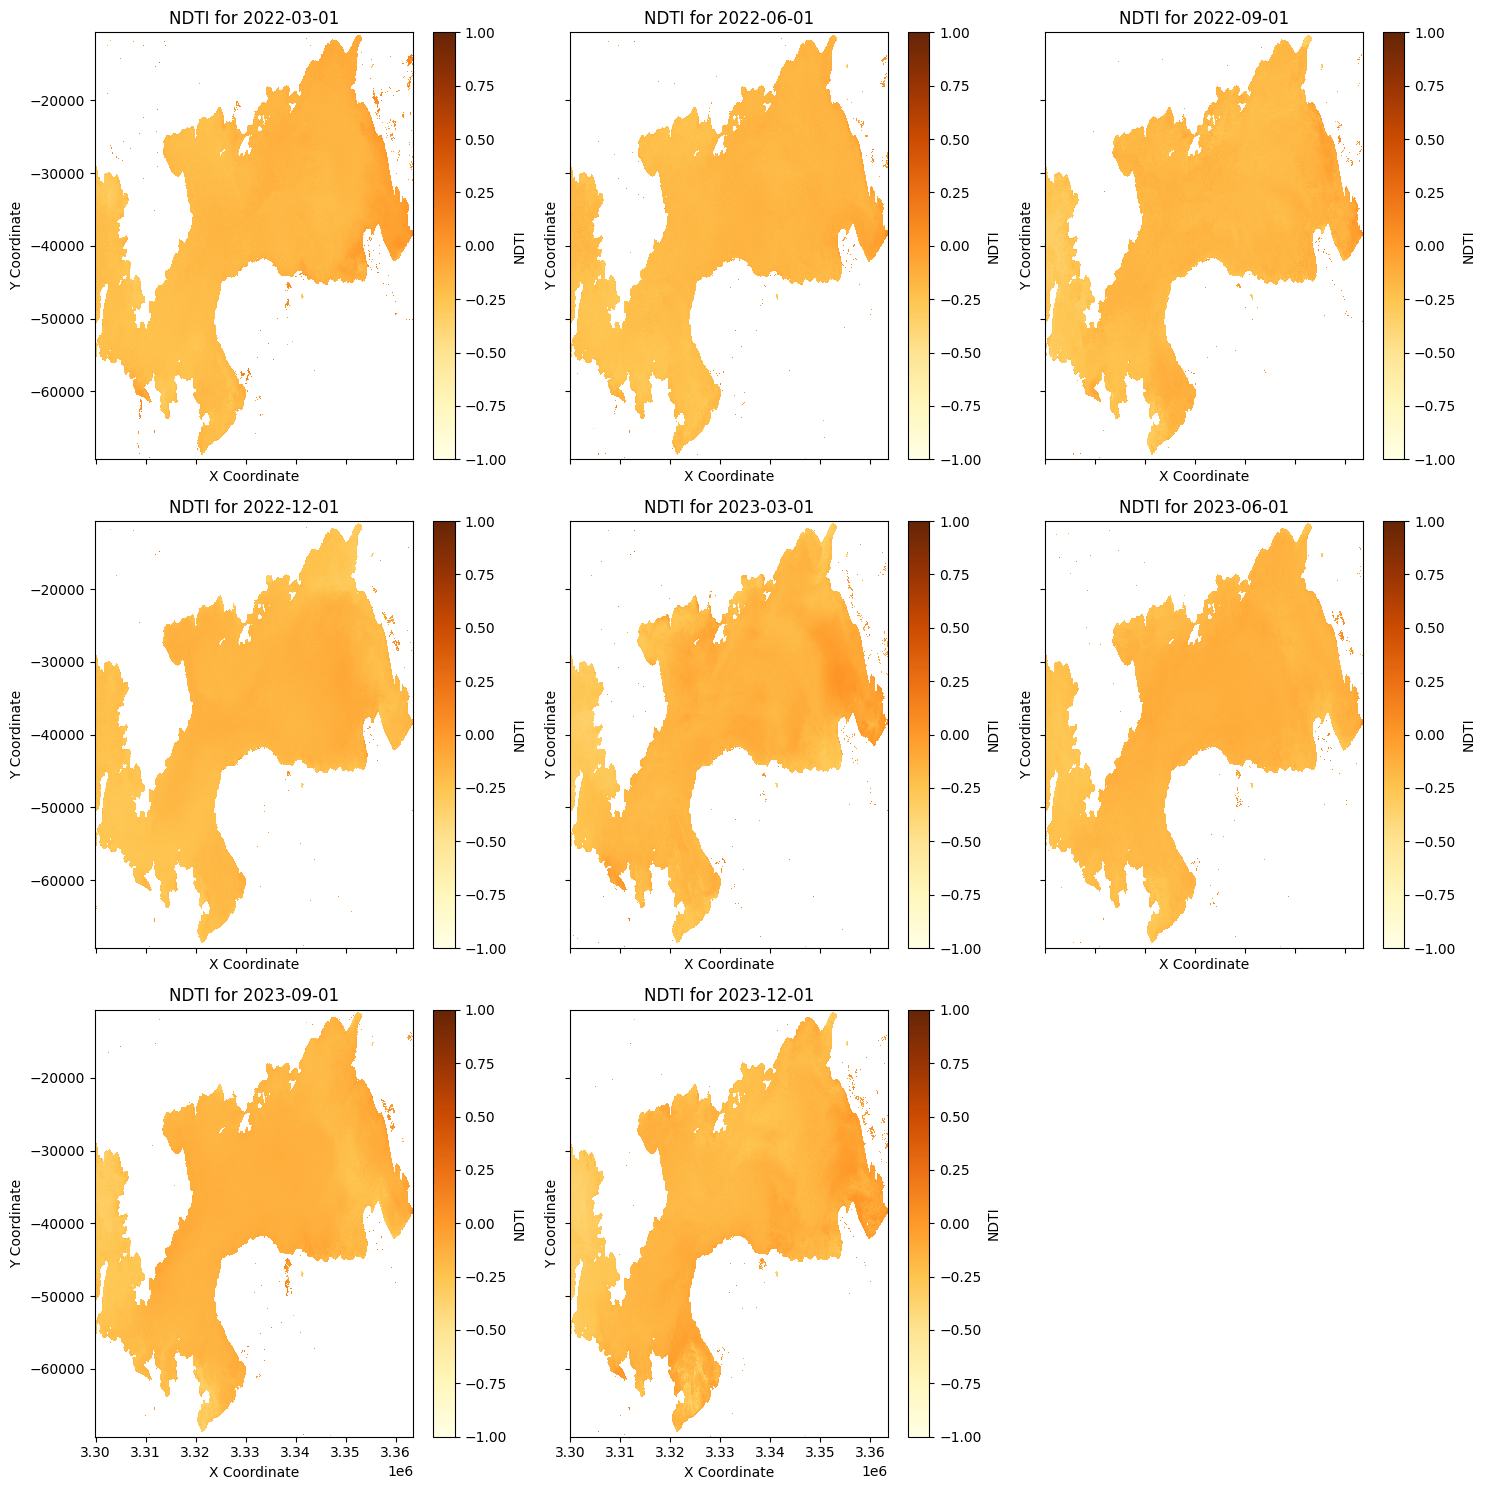

In [16]:
# Plot all time steps with available data
num_time_steps = len(ndti_QS.time)

# Calculate the number of subplots needed based on available time steps
num_cols = 3  # Number of columns for subplots
num_rows = (num_time_steps // num_cols) + (1 if num_time_steps % num_cols else 0)  # Calculate number of rows

# Set figure size based on the number of subplots
fig_width = 15
fig_height = num_rows * 5

# Create the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)

# Flatten axes if necessary
if num_rows == 1:
    axes = [axes]

# Plot each available time step
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        # Calculate the index of the current time step
        step_index = i * num_cols + j
        if step_index < num_time_steps:
            # Extract NDTI values for the current time step
            ndti_slice = ndti_QS.isel(time=step_index)
            # Plot the imagery
            ndti_slice.plot(ax=ax, cmap='YlOrBr', vmin=-1, vmax=1)  # Adjust colormap and vmin/vmax as needed
            # Set the title to display the date of the NDTI image
            date_str = str(ndti_slice.time.values)[:10]  # Extract the date part
            ax.set_title('NDTI for {}'.format(date_str))
            ax.set_xlabel('X Coordinate')
            ax.set_ylabel('Y Coordinate')
        else:
            # If no data available for this subplot, remove it
            ax.axis('off')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


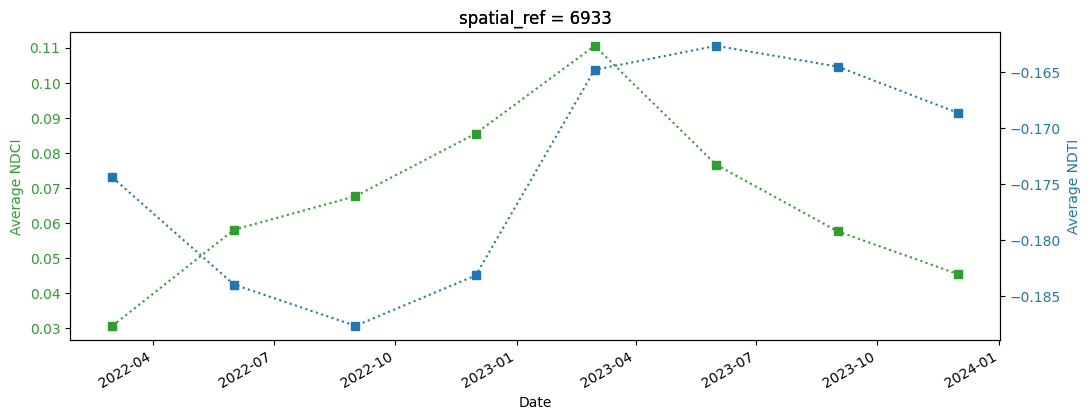

In [17]:
# Plot average NDCI and NDTI on the same plot with primary and secondary axes
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot average NDCI on the primary axis
color = 'tab:green'
average_ndci.plot(ax=ax1, linestyle=":", marker="s", color=color)
ax1.set_ylabel('Average NDCI', color=color)  # Set custom label for y-axis
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary axis for average NDTI
ax2 = ax1.twinx()
color = 'tab:blue'
average_ndti.plot(ax=ax2, linestyle=":", marker="s", color=color)
ax2.set_ylabel('Average NDTI', color=color)  # Set custom label for y-axis
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis label (if needed)
ax1.set_xlabel('Date')  # Set custom label for x-axis

plt.show()


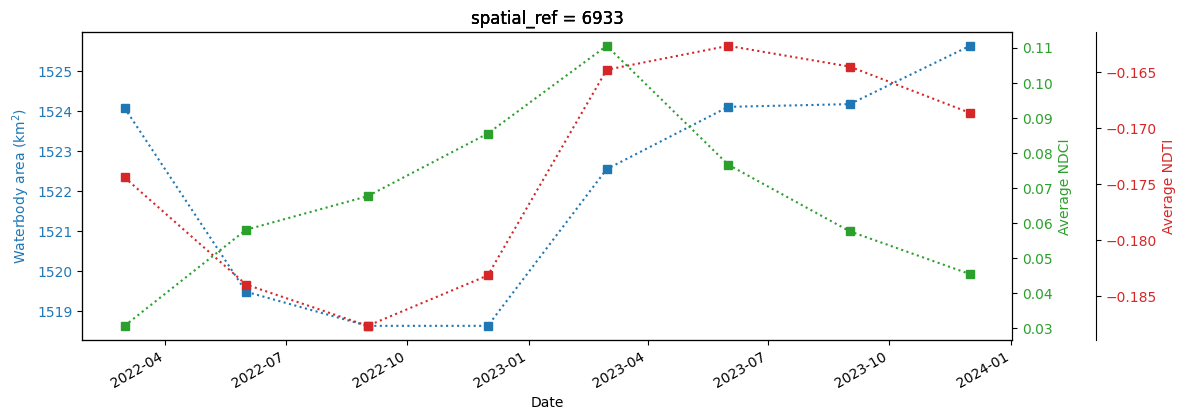

In [18]:
# Plot all three variables on the same plot
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot water area on the primary axis
color_waterarea = 'tab:blue'
waterarea.plot(ax=ax1, linestyle=":", marker="s", color=color_waterarea)
ax1.set_xlabel('Date')
ax1.set_ylabel('Waterbody area (km$^2$)', color=color_waterarea)
ax1.tick_params(axis='y', labelcolor=color_waterarea)

# Create a secondary axis for average NDCI on the right side
ax2 = ax1.twinx()
color_ndci = 'tab:green'
average_ndci.plot(ax=ax2, linestyle=":", marker="s", color=color_ndci)
ax2.set_ylabel('Average NDCI', color=color_ndci)
ax2.tick_params(axis='y', labelcolor=color_ndci)


# Create a third axis for average NDTI on the right side
ax3 = ax1.twinx()
color_ndti = 'tab:red'
average_ndti.plot(ax=ax3, linestyle=":", marker="s", color=color_ndti)
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Average NDTI', color=color_ndti)
ax3.tick_params(axis='y', labelcolor=color_ndti)

plt.show()


### Calculate correlation

In [19]:
# Calculate the correlation coefficients
correlation_ndci_ndti = np.corrcoef(average_ndci, waterarea)[0, 1]
correlation_ndci_waterarea = np.corrcoef(average_ndci, waterarea)[0, 1]
correlation_ndti_waterarea = np.corrcoef(average_ndti, waterarea)[0, 1]

# Print the correlation coefficients
print(f"Correlation Coefficient (NDCI, NDTI): {correlation_ndci_ndti}")
print(f"Correlation Coefficient (NDCI, Water Area): {correlation_ndci_waterarea}")
print(f"Correlation Coefficient (NDTI, Water Area): {correlation_ndti_waterarea}")

Correlation Coefficient (NDCI, NDTI): -0.35109991342508523
Correlation Coefficient (NDCI, Water Area): -0.35109991342508523
Correlation Coefficient (NDTI, Water Area): 0.8580740512557185


In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')